# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install phik -q
!pip install -Uq scikit-learn

In [2]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

RANDOM_STATE=42

## Описание данных

In [3]:
pth1 = 'autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные находятся в файле /datasets/autos.csv
- Признаки:
    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - Repaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя
- Целевой признак:
    - Price — цена (евро)

### Вывод:
- Значимые признаки:
    - VehicleType, тип автомобильного кузова опрееляет функционал машины, следовательно, влияет на стоимость автомобиля
    - RegistrationYear, с каждым годом стоимость машины падает, чем старее авто, тем оно дешевле
    - Gearbox, автоматическая коробка передач дороже механической
    - Power, чем больше лошидинных сил, тем дороже машина
    - Model, некоторые модели более популярны среди покупателей, чем другие, это влияет на стоимость
    - Kilometer, чем больше машина использовалась, тем больше она изношена, тем меньше её стоимость
    - FuelType, влияет на цену, напрмер, дизельные машины устроенны сложнее, поэтому стоят дороже
    - Brand, компания производитель отвечает не только за качество машины, но и социальный стутус водителя, поэтому цена варьируется
    - Repaired, любое ДТП снижает стоимость автомобиля
- Оставшиеся признаки не несут смысловой нагрузки в рамках выполняемой задачи

## Подготовка данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [8]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
def plot_col(df, column):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.ylabel('Частота')
    plt.title(f'{column}')
    sns.histplot(df[column])
    plt.subplot(1, 2, 2)
    plt.title(f'{column}')
    sns.boxplot(x=df[column])
    
def plot_cat(df, column):
    plt.figure(figsize=(15, 3))
    plt.ylabel('Частота')
    plt.title(f'{column}')
    inf = df[column].value_counts()
    sns.barplot(x=inf.index, y=inf)

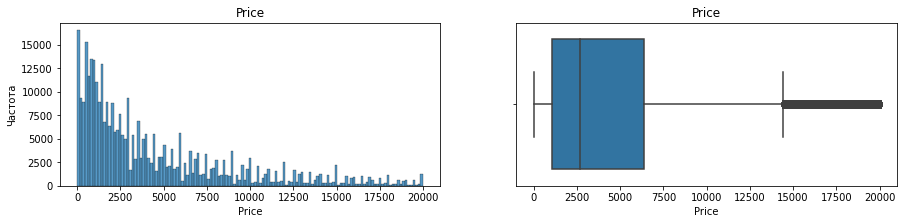

In [10]:
plot_col(df, 'Price')

На современном рынке покупка машины стоимостью дешевле 1000 евро является крайне редкой удачей, поэтому ограничим значения снизу

In [11]:
df = df.query('Price > 1000')

Пропуски в VehicleType выделим в отдельную категорию 'unknown'

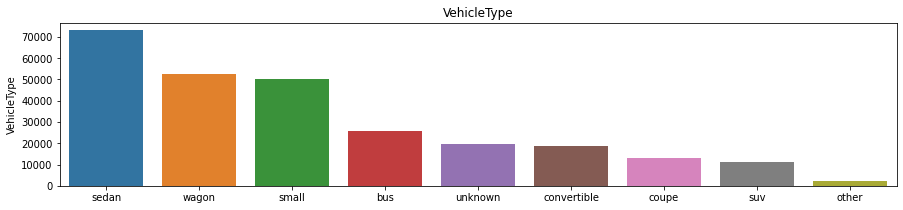

In [12]:
df['VehicleType'].fillna('unknown', inplace=True)
plot_cat(df, 'VehicleType')

In [13]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

В столбце RegistrationYear имеются выбросы. По верхней границе - автомобиль не мог быть зарегистрирован позже самой поздней даты выгрузки данных, иначе это данные из будущего. По нижней границе - первый прототип современного автомобиля был создан в 1885 году, следовательно, все автомобили, которые были якобы зарегистрированы ранее, являются выбросами. Удалим некорректные данные

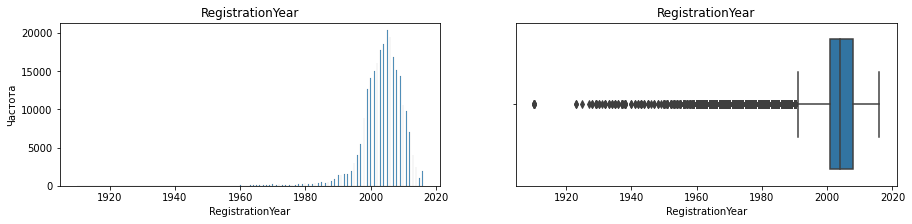

In [14]:
df_1885 = df.query('RegistrationYear >= 1885 & RegistrationYear < 2016')
df_2016 = df.query('RegistrationYear == 2016 & RegistrationMonth <= 4')\
                .drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df = pd.concat([df_1885, df_2016]).reset_index(drop=True)
plot_col(df, 'RegistrationYear')

Воспользовавшись данными из малозначимых признаков, мы можем их удалить.

In [15]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

Большинство современных машин, имеющие автоматическую коробку передач, оснащены возможностью механического переключения передач, поэтому будем считать, что автомат это дополнение, и если его не указали в данных, значит, в машине стоит механика. Заполним пропуски в Gearbox

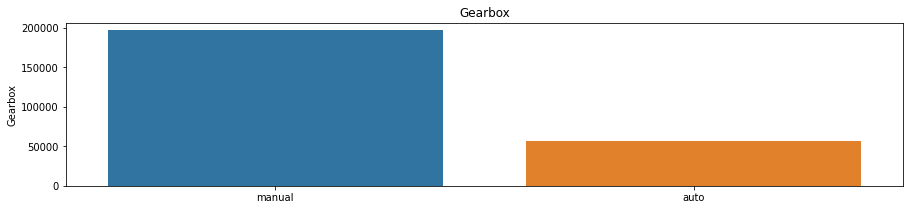

In [16]:
df['Gearbox'].fillna('manual', inplace=True)
plot_cat(df, 'Gearbox')

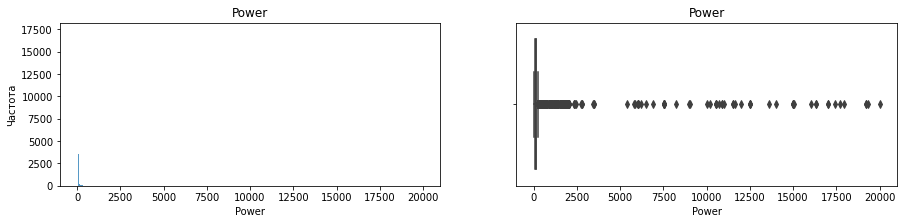

In [17]:
plot_col(df, 'Power')

Из графика видно наличие большого количества выбросов. В современном мире самой мощной машиной является Devel Sixteen — 5 007 л. с. Попробуем ограничить данные этим значением

In [18]:
df = df.query('Power < 5007')

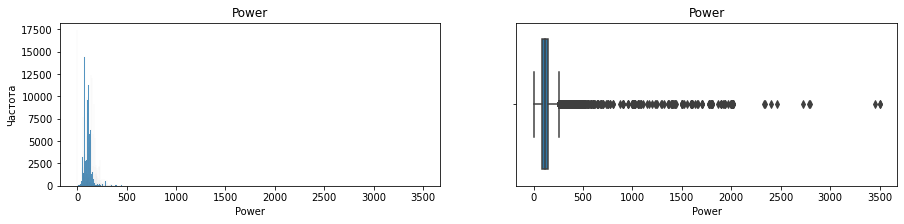

In [19]:
plot_col(df, 'Power')

По-прежнему наблюдаем выбросы. Удалим аномальные данные, а также и те, что не соответствуют логике, например, мощность, равная 0 л.с.

In [20]:
df = df.query('20 < Power < 400')

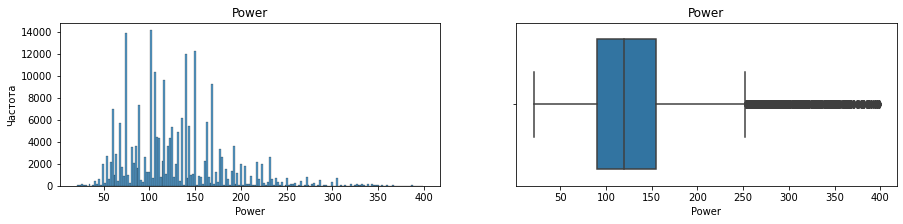

In [21]:
plot_col(df, 'Power')

Аналогично VehicleType заполним пропуски в столбце Model

In [22]:
df['Model'].fillna('unknown', inplace=True)

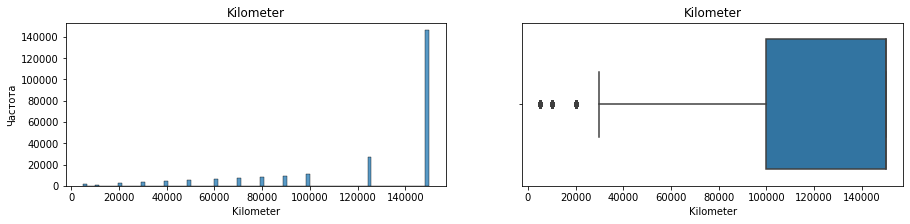

In [23]:
plot_col(df, 'Kilometer')

В столбце Kilometer всё хорошо, так как у машин может быть разный пробег

Пропуски в FuelType заменим на самое распространенный тип среди машин данной модели

In [24]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

petrol      145680
gasoline     84855
lpg           4030
cng            436
hybrid         189
other           51
electric        33
Name: FuelType, dtype: int64


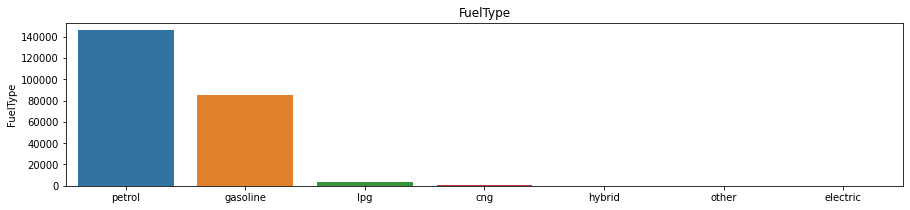

In [25]:
print(df['FuelType'].value_counts())
plot_cat(df, 'FuelType')

In [26]:
print(df['Brand'].value_counts())

volkswagen        50821
bmw               29011
mercedes_benz     24809
audi              22478
opel              21566
ford              14113
renault            8918
peugeot            7201
fiat               5021
skoda              4624
seat               4503
smart              4112
toyota             3644
mazda              3608
citroen            3353
mini               2927
nissan             2884
hyundai            2721
volvo              2142
honda              1807
kia                1803
mitsubishi         1601
suzuki             1544
alfa_romeo         1541
sonstige_autos     1489
chevrolet          1348
chrysler            894
dacia               777
porsche             571
jeep                565
land_rover          459
subaru              425
jaguar              423
saab                365
daihatsu            330
lancia              209
daewoo              193
trabant             172
rover               167
lada                135
Name: Brand, dtype: int64


В столбце Brand всё хорошо, так как у машин может быть разный бренд-производитель

Пропуски в Repaired возникли скорее всего из-за того, что если автомобиль не был поврежден, то этот параметр просто не заполнялся, поэтому заменим пропуски на 'no'

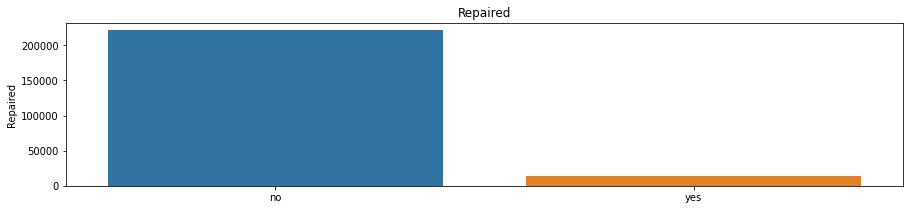

In [27]:
df['Repaired'].fillna('no', inplace=True)
plot_cat(df, 'Repaired')

In [28]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [29]:
phik_overview = df.phik_matrix(interval_cols=['Price', 'Power'])

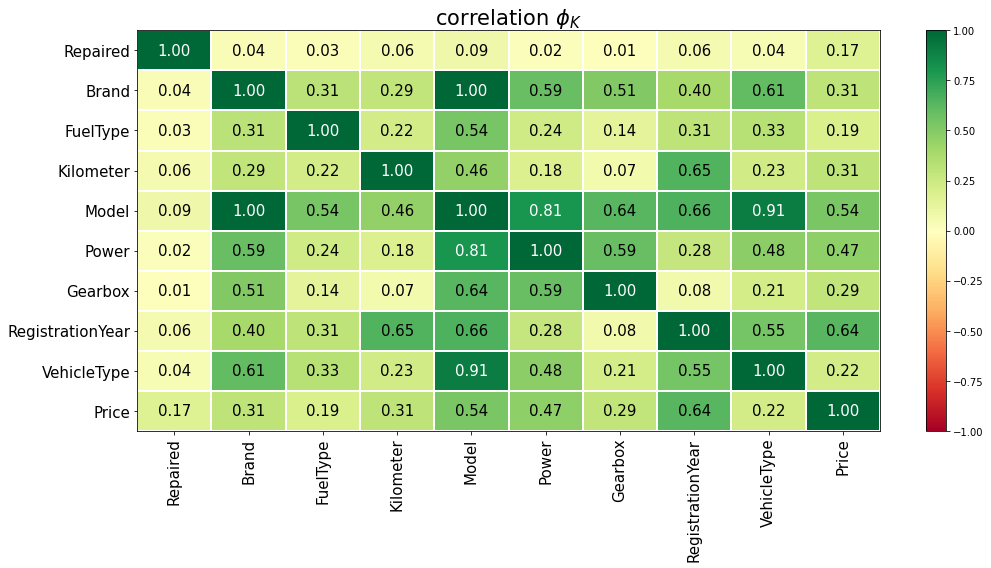

In [30]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 8)
)

Из таблицы видно, что признак 'Model' сильно коррелирует с 'Brand' (1.00), 'VehicleType' (0.90), 'Power' (0.81). Это можно привести к неустойчивости обучаемой модели, поэтому исключим признак 'Model' из данных.

In [31]:
df = df.drop('Model', axis=1)

### Вывод:
- Было выделено 9 главных признаков: 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired'
- Явные дубликаты были удалены
- Пропуски в каждом столбце были заполнены согласно здравому смыслу
- Выбросы в данных были выявлены, прокомментированы и устранены
- Признак 'Model' сильно коррелирует с 'Brand' (1.00), 'VehicleType' (0.90), 'Power' (0.81). Это можно привести к неустойчивости обучаемой модели, поэтому исключим признак 'Model' из данных

## Обучение моделей

In [32]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

In [33]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [34]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [35]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [36]:
param_grid_1 = [
    {
        'models': [DummyRegressor()],
        'models__strategy': ['mean', 'median'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

param_grid_2 = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

param_grid_3 = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 7),
        'models__max_features': range(5, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

param_grid_4 = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate': [0.1, 0.15, 0.2],
        'models__num_leaves': [50, 100, 150],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [37]:
grid_1 = GridSearchCV(pipe_final,
                   param_grid_1,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1)

grid_2 = GridSearchCV(pipe_final,
                   param_grid_2,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1)

grid_3 = GridSearchCV(pipe_final,
                   param_grid_3,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1)

grid_4 = GridSearchCV(pipe_final,
                   param_grid_4,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1)

In [38]:
grid_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [DummyRegressor()],
                          'models__strategy': ['mean', 'median'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_mean_squared_error')

In [39]:
grid_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_mean_squared_error')

In [40]:
grid_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 7),
                          'models__max_features': range(5, 7),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_mean_squared_error')

In [41]:
grid_4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMRegressor(random_state=42)],
                          'models__learning_rate': [0.1, 0.15, 0.2],
                          'models__num_leaves': [50, 100, 150],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_mean_squared_error')

In [56]:
def time_test(model, X_train, y_train):
    rmse = round((model.best_score_ * (-1)) ** 0.5, 2)
    
    start = time.time()
    model.best_estimator_.fit(X_train, y_train)
    end = time.time()
    train_time = round((end - start) / 60, 3)

    start = time.time()
    y_pred = model.best_estimator_.predict(X_train)
    end = time.time()
    pred_time = round((end - start) / 60, 3)

    return [train_time, pred_time, rmse]

In [57]:
info_1 = time_test(grid_1, X_train, y_train)
info_2 = time_test(grid_2, X_train, y_train)
info_3 = time_test(grid_3, X_train, y_train)
info_4 = time_test(grid_4, X_train, y_train)

In [58]:
info_1

[0.009, 0.007, 4579.97]

In [59]:
info_2

[0.044, 0.01, 2854.04]

In [60]:
info_3

[0.014, 0.008, 3345.8]

In [61]:
info_4

[0.154, 0.042, 1653.7]

## Анализ моделей

In [62]:
result = pd.DataFrame(data=[info_1, info_2, info_3, info_4], index=["DummyRegressor", "LinearRegression", 
                                                          "DecisionTreeRegressor", "LGBMRegressor"], 
             columns=["fit_time", "predict_time", "RMSE"])
result.sort_values('RMSE', ascending=True)

,fit_time,predict_time,RMSE
LGBMRegressor,0.154,0.042,1653.70
LinearRegression,0.044,0.010,2854.04
DecisionTreeRegressor,0.014,0.008,3345.80
DummyRegressor,0.009,0.007,4579.97


Требования заказчика:
- RMSE < 2500
- RMSE минимальная
- Скорость обучения/предсказания минимальна

Следовательно, лучшей моделью будет LGBMRegressor.

In [63]:
y_pred = grid_4.best_estimator_.predict(X_test)
print('RMSE лучшей модели на тестовой выборке:', round(mean_squared_error(y_test, y_pred) ** 0.5, 2))

RMSE лучшей модели на тестовой выборке: 1647.49


## Общий вывод

- Учитывая предпочтения заказчика, лучшей моделью будет LGBMRegressor. Она показала лучшую метрику RMSE и среднее время обучения/предсказания
- В ходе работы были отобраны значимые признаки:
    - VehicleType, тип автомобильного кузова опрееляет функционал машины, следовательно, влияет на стоимость автомобиля
    - RegistrationYear, с каждым годом стоимость машины падает, чем старее авто, тем оно дешевле
    - Gearbox, автоматическая коробка передач дороже механической
    - Power, чем больше лошидинных сил, тем дороже машина
    - Model, некоторые модели более популярны среди покупателей, чем другие, это влияет на стоимость
    - Kilometer, чем больше машина использовалась, тем больше она изношена, тем меньше её стоимость
    - FuelType, влияет на цену, напрмер, дизельные машины устроенны сложнее, поэтому стоят дороже
    - Brand, компания производитель отвечает не только за качество машины, но и социальный стутус водителя, поэтому цена варьируется
    - Repaired, любое ДТП снижает стоимость автомобиля
Оставшиеся признаки не несут смысловой нагрузки в рамках выполняемой задачи
- Над отобранными признаками была проведена предобработка:
    - Явные дубликаты были удалены
    - Пропуски в каждом столбце были заполнены согласно здравому смыслу
    - Выбросы в данных были выявлены, прокомментированы и устранены
    - Признак 'Model' сильно коррелирует с 'Brand' (1.00), 'VehicleType' (0.90), 'Power' (0.81). Это можно привести к неустойчивости обучаемой модели, поэтому исключим признак 'Model' из данных
- Признаки были закодированы с помощью OneHotEncoder
- Были обучены и протестированы 4 модели: DummyRegressor, LinearRegression, DecisionTreeRegressor, LGBMRegressor
- Был проведен анализ времени обучения, предсказания и метрики RMSE